<a href="https://colab.research.google.com/github/SaketMunda/tensorflow-fundamentals/blob/master/02_neural_network_classfication_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to neural network classification with tensorflow

A classification problem involves predicting whether something is one thing or another.

In this notebook we will see below types of classification problem,
* **Binary classification**
* **Multi-class classification**
* **Multi-label classification**

## Typical architecture of a classification neural network

The word *typical* is on purpose.

Because the architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:
* An Input layer
* Some Hidden layer
* An output layer

The following are some standard values you'll often use in your classification neural networks,

| **Hyperparameter** | **Binary Classfication** | **Multiclass Classfication** | 
| --- | --- | --- |
| Input layer shape | Same shape as number of features (e.g. 3 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) (`tf.keras.losses.BinaryCrossentropy` in TensorFlow) | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) (`tf.keras.losses.CategoricalCrossentropy` in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

***Table 1:*** *Typical architecture of a regression network.* ***Source:*** *Adapted from page 293 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*


In [1]:
# let's start by importing tensorflow
import tensorflow as tf
print(tf.__version__)

2.9.2


## Creating data to view and fit

We could start by importing a classification dataset but let's practice making some own classification data,

> 🔑 It's common practice to get you and model you build working on a toy (or   simple) dataset before moving to your actual problem. Treat it as a rehersal experiment before the actual experiment(s).

We'll use Scikit-learn's `make_circles()` function.

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
# Let's check the shapes and size
X.shape, y.shape

((1000, 2), (1000,))

In [4]:
# check the values
X[:10]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343],
       [-0.47964637,  0.67643477],
       [-0.01364836,  0.80334872],
       [ 0.77151327,  0.14775959],
       [-0.16932234, -0.79345575],
       [-0.1214858 ,  1.02150905]])

In [5]:
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

But seeing the data in this format is not speaking out anyting. Let's visualize it first.

In [6]:
# converting them into pandas
import pandas as pd

circles = pd.DataFrame({"X0": X[:,0], "X1": X[:,1], "label":y})
circles.head(10)

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [7]:
# check out the different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

We can see that we have labels as `0` or `1`, it means that we're going to solve **binary classification problem**.

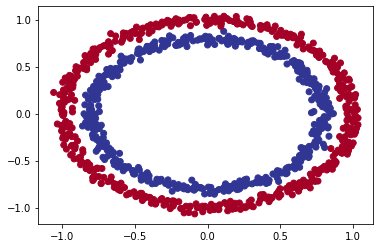

In [8]:
# visualize with the plot
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="RdYlBu");

Nice! From the plot, can you guess what kind of model we want to build ?

How about we try to build one to classify blue or red dots ? As in, a model which is able to distinguish blue from red dots.

> **Practice** : [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,2&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true)

## Input and Output Shapes

One of the most common issue you'll run into when building deep neural networks is shape mismatches.

More specifically, the shape of the input data and the shape of output data.

In our case, we want to input `X` and get our model to predict `y`

So let's check out the shapes of `X` and `y`.

In [9]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

Where do these numbers come from ?

In [10]:
len(X), len(y)

(1000, 1000)

So we've got as many `X` values as we do `y` values, that makes sense.

In [11]:
# View the first example of features and labels
X[2], y[2]

(array([-0.81539193,  0.17328203]), 1)

Alright, so we've got two `X` features which lead to one `y` value.

This means our neural network input shape will has to accept a tensor with at least one dimension being two and output a tensor with at least one value.


> 🤔 **Note**: `y` having a shape of (1000,) can seem confusing. However, this is because all `y` values are actually scalars (single values) and therefore don't have a dimension. For now, think of your output shape as being at least the same value as one of example of `y`(in our case, the output from our neural network has to be at least one value)



## Steps in modelling

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model**: piece together the layers of neural network yourself(using the functional or Sequential API) or import a previously built model(known as transfer learning).
2. **Compiling a model**: defining how a model's performance should be measured(loss/metrics) as well as defining how it should improve(optimizer).
3. **Fitting a model**: letting the model try to find patterns in the data(how does `X` get to `y`).

Let's see these in action using Sequential API to build a model for our regression data. And then we'll step through each.

In [12]:
# set the random seed
tf.random.set_seed(17)

# 1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile a model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])

# 3. Fitting a model
model.fit(X, y, epochs = 100, verbose=0)

In [13]:
# 4. Evaluating a model
model.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5000


[0.6931850910186768, 0.5]

Looking at the accuracy metric, our model performs poorly (50% accuracy on a binary classification problem is the equivalent of guessing), but what if we trained it for longer?

In [14]:
# Train our model for longer,
model.fit(X, y, epochs=200,verbose=0)
model.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5000


[0.6933965086936951, 0.5]

So even if we have trained our model for little longer than previous, it is not improving, it's performing like it's guessing.

What if we added an extra layer and trained for a little longer ?

In [15]:
# set random seed
tf.random.set_seed(17)

# 1. Create a model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(1), # add an extra layer
    tf.keras.layers.Dense(1)
])

# 2. Compile a model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["accuracy"])
# 3. Fit a model
model_1.fit(X, y, epochs=200, verbose=0)

# 4. Evaluate a model
model_1.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.5000


[7.712474346160889, 0.5]

So even we have added an extra layer the model is not improving.

Let's see what are things we have to do to improve our models.

## Improving a model

To improve a model, we can alter almost every part of the 3 steps we went thrugh before.

1. **Creating a model**: here we might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model**: you might want to choose a different optimization function (such as Adam optimizer, which is usually pretty good for any problems) or perhaps change the learning rate of the optimization function.
3. **Fitting a model**: we might train our model little longer by increasing the value of epochs.


How about first try adding more neurons, an extra layer and choose Adam as optimizer function?

In [16]:
# set the random seed
tf.random.set_seed(17)

# Create a model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100), ## adding an extra layer with 100 neurons
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dense(1)
])

# Compile a model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fitting a model
model_2.fit(X, y, epochs=200, verbose=0)

# Evaluating a model
model_2.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4150


[0.6936585903167725, 0.41499999165534973]

Oh !

Accuracy decreases more.

We've pulled out a few tricks but our model isn't even doing better than guessing.

Let's make some visualization to see what's happening.

> 🔑 **Note**: Whenever your model is performing strangely or there's something going on with your data you're not quite sure of, remember these three words: **Visualize**, **Visualize**, **Visualize**. Inspect your data, inspect your model, inspect your model's predictions.

To visualize our model's predictions we're going to create a function `plot_decision_boundary()` which:
* Takes in a trained model, features `X` and labels `y`.
* Create a [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) of the different `X` values.
* Makes predictions across the meshgrid.
* Plots the predictions as well as a line between the different zones (where each unique class falls)

If this sounds confusing, let's see it in code and then see the output.

In [17]:
import numpy as np

In [18]:
def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function is adapated from two phenomenal resources:
  1. CS231n - https://cs231n.github.io/neural-networks-case-study/
  2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together

  # Make predictions using trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # check the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
    print("doing multi-class classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classification...")
    y_pred = np.round(np.max(y_pred, axis = 1)).reshape(xx.shape)

  
  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:,0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

Now we've got a function to plot our model's decision boundary (the cut off point its making between red and blue dots), let's try it out.

313/313 [==============================] - 1s 1ms/step
doing binary classification...


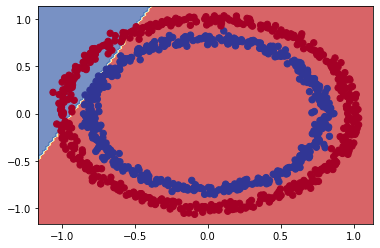

In [19]:
# check out the predictions our model is making
plot_decision_boundary(model_2, X, y)

Looks like our model is trying to draw a straight line through the data.

What's wrong with doing this ?

The main issue is our data isn't separable by a straight line.

In a regression problem, our model might work. In fact, let's try it.

In [20]:
# set random seed
tf.random.set_seed(17)

# create some regression data
X_regression = np.arange(0,1000,5)
y_regression = np.arange(100,1100,5)

# Split it into training and test sets
X_reg_train, y_reg_train = X_regression[:150], y_regression[:150]
X_reg_test, y_reg_test = X_regression[150:], y_regression[150:]

# Fit our model to the data
model_2.fit(tf.expand_dims(X_reg_train, axis = -1), y_reg_train, epochs = 100, verbose = 0)


ValueError: ignored

In [21]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               300       
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
Total params: 403
Trainable params: 403
Non-trainable params: 0
_________________________________________________________________


We compiled our model for a binary classification problem.

We can recreate it for a regression problem.

In [22]:
# setup the random seed
tf.random.set_seed(17)

# Recreate a model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

# compile a model, change the loss and metrics for regression model
model_3.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# fit the model
model_3.fit(tf.expand_dims(X_reg_train, axis = -1), y_reg_train, epochs=100, verbose=0)

In [23]:
# evaluate the model
model_3.evaluate(X_reg_test, y_reg_test)

2/2 [==============================] - 0s 6ms/step - loss: 56.8959 - mae: 56.8959


[56.895851135253906, 56.895851135253906]

Let's plot the predictions

2/2 [==============================] - 0s 6ms/step


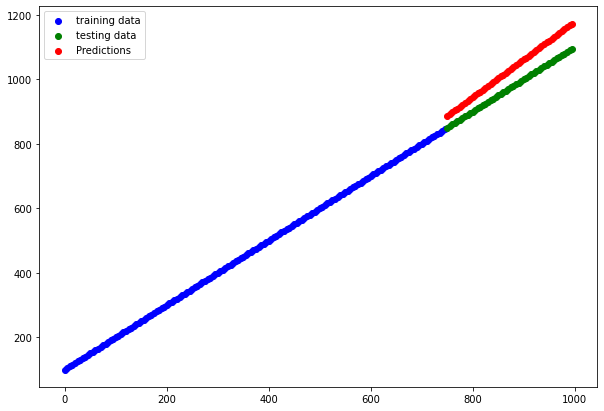

In [24]:
# Make a predictions with our trained model
y_reg_preds = model_3.predict(X_reg_test)

# plot the model's predictions against our regression data
plt.figure(figsize=(10, 7))
plt.scatter(X_reg_train, y_reg_train, c='b', label='training data')
plt.scatter(X_reg_test, y_reg_test, c='g', label='testing data')
plt.scatter(X_reg_test, y_reg_preds.squeeze(), c='r', label='Predictions')
plt.legend();

Okay, the predictions aren't perfect (if the predictions were perfect, the red would line up with the green), but they look better than complete guessing.

So this means our model must be learning something...

There must be something we are missing out on for our classification problem.

## The missing piece : Non-Linearity

Okay so we saw our neural network can model straight lines (with ability a little bit better than guessing).

What about non-straight lines (non-linear)?

If we're going to model our classification data (the red and blue circles), we're going to need some non-linear lines.

There is a concept of activation function while setting up the neural network layers, and there are multiple activation function and each has it's own use case.

Types of **Activation Function**:
* ReLu
* Softmax
* Linear
* Sigmoid

By default each layer has a activation function as `None`.

Since we are dealing with non-linear binary classification problem, so we can try with other activation function except `Linear`.

Let's do the modelling,

In [25]:
# set the random seed
tf.random.set_seed(17)

# 1. Create a model
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation="relu"), # 1 hidden layer with activation function Relu
    tf.keras.layers.Dense(1) # output layer
])

# 2. Compile a model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# 3. Fit the model
history = model_4.fit(X, y, epochs=200, verbose=0)

# 4. Evaluating
model_4.evaluate(X, y)

32/32 [==============================] - 1s 5ms/step - loss: 0.6992 - accuracy: 0.5000


[0.6992375254631042, 0.5]

Okay so it looks like that model is still guessing rather learning for this kind of inputs.

Let's tweak the things in [TensorFlow Playground](https://playground.tensorflow.org/) and immitate here.

![Image](https://drive.google.com/uc?export=view&id=1n_l6LZHfwYVlCiiBK52IMyylP2ytZWZT)

Let's mock the above settings into our model

In [26]:
# Set the random seed
tf.random.set_seed(17)

# Create a model
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1) # Output layer
])

# Compile a model
model_5.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# Fit the model
history = model_5.fit(X, y, epochs=200, verbose=0)

# Evaluate
model_5.evaluate(X,y)

32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000


[7.712474346160889, 0.5]

Hmmmm, Still it's not doing well. What's wrong with our model now.

I think there is one more missing thing, i.e **output layer activation function**.

This was mentioned in the *typical* **Architecture of Classification Neural Network**, that Output Layer should have activation function with `Sigmoid` for Binary Classification

Let's try that,

In [27]:
# set the random seed
tf.random.set_seed(17)

# create a model
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile a model
model_6.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# fit the model
history = model_6.fit(X, y, epochs=200, verbose=0)

# evaluating
model_6.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.0821 - accuracy: 0.9980


[0.08213627338409424, 0.9980000257492065]

Voila !! OMFG


See the accuracy, it is incredible.

Now let's plot our decision boundary using our function.

313/313 [==============================] - 0s 1ms/step
doing binary classification...


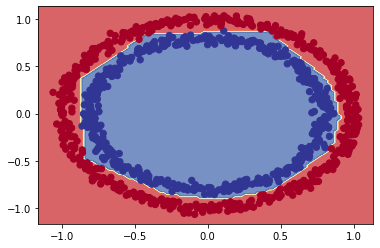

In [28]:
plot_decision_boundary(model_6, X, y)

**Before**:

When we model with basic settings

313/313 [==============================] - 0s 1ms/step
doing binary classification...


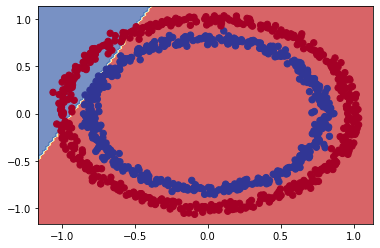

In [29]:
plot_decision_boundary(model_2, X, y)

We successfully improved our model by tweaking the settings of Neural Network layers

In [30]:
# let's see the summary of our successful model
model_6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 4)                 12        
                                                                 
 dense_15 (Dense)            (None, 4)                 20        
                                                                 
 dense_16 (Dense)            (None, 1)                 5         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 0, 'Epochs')

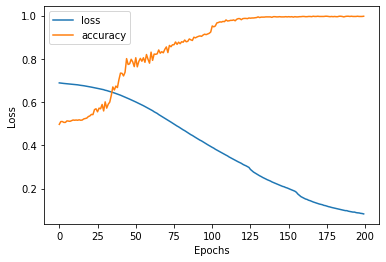

In [31]:
# and if we plot the history
import pandas as pd
pd.DataFrame(history.history).plot()
plt.ylabel("Loss")
plt.xlabel("Epochs")

🤔 **Question**: What's wrong the predictions we've made ? Are we really evaluating our model correctly? Hint: What data did the model learn on and what data did we predict on ?

🔑 **Note**: The combination of **linear(straight lines)** and **non-linear(non-straight lines)** functions is one of the key fundamentals of neural networks.

Think of it like this:

If we have an unlimited amount of straight and non-straight lines, what kind of patterns could we draw ?

That's essentially what neural networks do to find patterns in data.

Now we might be thinking, "but I haven't seen a linear function or a non-linear function before..."

Oh but we have.

We've been using them the whole time.

They're what power the layers in the models we just built.

To get some intuition about the activation functions we've just used, let's create them and then try them on some toy data.

In [32]:
# Create a toy tensor data
A = tf.cast(tf.range(-10,10), tf.float32)
A

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

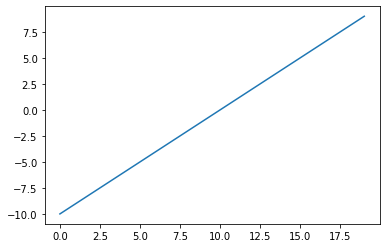

In [33]:
plt.plot(A)

In [34]:
# Let's see what Sigmoid activation function do,
# sigmoid(x) = 1 / 1 + exp(-x)

def sigmoid(x):
  return 1 / (1 + tf.exp(-x))

# Let's see what sigmoid return with our toy tensor
sigmoid(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([4.5397872e-05, 1.2339458e-04, 3.3535014e-04, 9.1105117e-04,
       2.4726233e-03, 6.6928510e-03, 1.7986210e-02, 4.7425874e-02,
       1.1920292e-01, 2.6894143e-01, 5.0000000e-01, 7.3105860e-01,
       8.8079703e-01, 9.5257413e-01, 9.8201376e-01, 9.9330717e-01,
       9.9752742e-01, 9.9908900e-01, 9.9966466e-01, 9.9987662e-01],
      dtype=float32)>

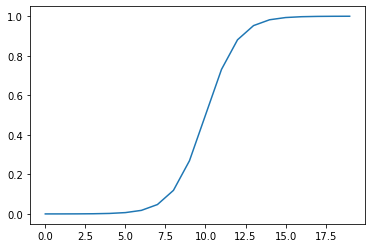

In [35]:
# ploting
plt.plot(sigmoid(A));

So basically Sigmoid function turns our input to create patterns with some curve lines.

In [36]:
# Let's see reLu function which is max(x, 0)
def relu(x):
  return tf.maximum(0, x)

# see what our toy tensor looks like
relu(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6.,
       7., 8., 9.], dtype=float32)>

So relu activation function, converts all the -ve numbers into 0 and keep the +ve number as it is.

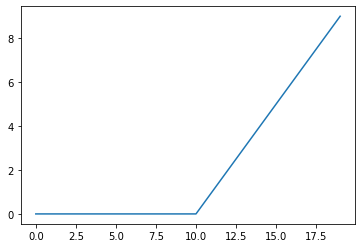

In [37]:
# plot the relu function
plt.plot(relu(A));

And it gives the bend lines to create pattern.

In [38]:
# Checking linear function, which says it doesn't modify anything
tf.keras.activations.linear(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

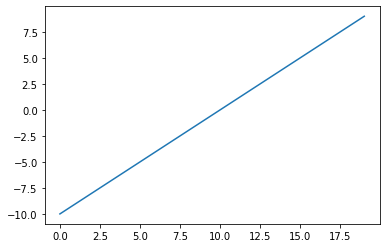

In [39]:
# it will draw the same plot as it was for A
plt.plot(tf.keras.activations.linear(A))

Activation functions are basically modify our inputs into some output for that layer and become an input for the next layer.

Non-linear functions are able to deduce patterns in non-linear data whereas Linear functions cannot.

📖 **Resource**: [Machine Learning Cheatsheet](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html) for more on activation functions.

## Evaluating and Improving a Model

We've evaluating our model into the same data that we used for training which is not a good practice.

We should divide our dataset into training and test set atleast.

In [40]:
# Length of our toy tensor
len(X)

1000

In [41]:
# Spliting the data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
# Checking the shape of the train and test split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

Great, now we've got our training and test data sets, let's model the training data and evaluate on test data.

In [45]:
# set the random seed
tf.random.set_seed(17)

# 1. Create a model
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') # output layer
])

# 2. Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=['accuracy'])
# 3. Fit the model
history = model_7.fit(X_train, y_train, epochs=25)

Epoch 1/25
25/25 [==============================] - 1s 4ms/step - loss: 0.6889 - accuracy: 0.5150
Epoch 2/25
25/25 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.5813
Epoch 3/25
25/25 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.5925
Epoch 4/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6697 - accuracy: 0.5350
Epoch 5/25
25/25 [==============================] - 0s 4ms/step - loss: 0.6577 - accuracy: 0.5663
Epoch 6/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6700
Epoch 7/25
25/25 [==============================] - 0s 4ms/step - loss: 0.6231 - accuracy: 0.6888
Epoch 8/25
25/25 [==============================] - 0s 4ms/step - loss: 0.5964 - accuracy: 0.7663
Epoch 9/25
25/25 [==============================] - 0s 3ms/step - loss: 0.5693 - accuracy: 0.7850
Epoch 10/25
25/25 [==============================] - 0s 3ms/step - loss: 0.5333 - accuracy: 0.8363
Epoch 11/25
25/25 [

**Learning rate is the frequency of the model to learns (or optimize itself) while training per epochs**. The higher the value the faster the learning rate is.

In [46]:
# Evaluating the model on test set
model_7.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.1187 - accuracy: 1.0000


[0.11866895854473114, 1.0]

Alright it looks like the model is trained very well to identify the patterns and on test set it performed with outputing the result as 100% accuracy.

Let's plot the decision boundary to compare the prediction between **training** and **test** set.

313/313 [==============================] - 5s 14ms/step
doing binary classification...
313/313 [==============================] - 2s 5ms/step
doing binary classification...


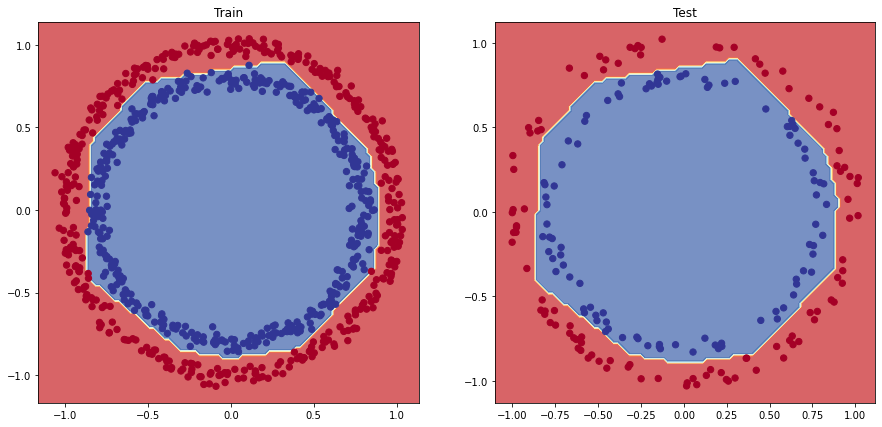

In [53]:
# Plotting the decision boundary of training samples
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_7, X_train, y_train)

# Plotting the decision boundary of test samples
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_7, X_test, y_test)

plt.show()

## Plot the loss (or training) curves

Looking at the plots above, we can see the outputs of our model are very good.

But how did our model go whilst it was learning ?

As in, how did the performance change everytime the model had a chance to look at the data (once every epoch)?

For that, we have assigned the `fit` function to `history` variable.

This is where we'll get the information for how our model is performing as it learns.

In [54]:
# We can acess the information in the history variable by it's .history attribute
pd.DataFrame(history.history)

,loss,accuracy
0,0.688858,0.51500
1,0.683743,0.58125
2,0.678810,0.59250
3,0.669689,0.53500
4,0.657720,0.56625
5,0.642320,0.67000
6,0.623101,0.68875
7,0.596419,0.76625
8,0.569300,0.78500
9,0.533342,0.83625


Text(0.5, 1.0, 'Model_7 training curves')

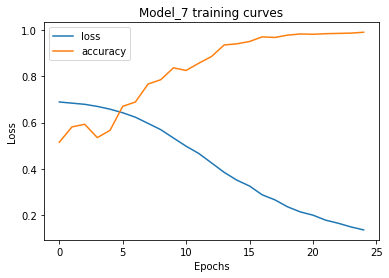

In [56]:
# If we plot it
pd.DataFrame(history.history).plot()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model_7 training curves")

## Finding the best learning rate

Aside from the architecture itself (the layers, number of neurons, activations etc), the most important hyperparameter you can tune for your neural network models is the learning rate.

In `model_7`, we have increased the Adam optimizer's learning from the default of `0.001`(default) to `0.1`

It was a lucky guess.

But ideally it is not the way, and we won't be fortunate everytime.

So we might need to find another way to obtain the best learning rate.

To do so, we're going to use the following:

* A [Learning rate callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler)
 - We can think of a callback as an extra piece of functionality we can add to our model while it's training.
* Another model
* A modified loss curves plot

In [78]:
# set the random seed
tf.random.set_seed(17)

# Create the model
model_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_8.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# Create a Learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))
# traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch

# Now fit the model
history_8 = model_8.fit(X_train, y_train, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
25/25 [==============================] - 1s 2ms/step - loss: 0.6891 - accuracy: 0.5013 - lr: 1.0000e-04
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6890 - accuracy: 0.5025 - lr: 1.1220e-04
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6889 - accuracy: 0.5000 - lr: 1.2589e-04
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6887 - accuracy: 0.5038 - lr: 1.4125e-04
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6885 - accuracy: 0.5063 - lr: 1.5849e-04
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6883 - accuracy: 0.5050 - lr: 1.7783e-04
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6881 - accuracy: 0.5075 - lr: 1.9953e-04
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5075 - lr: 2.2387e-04
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss:

Now our model has finished training, let's have a look at the training history.

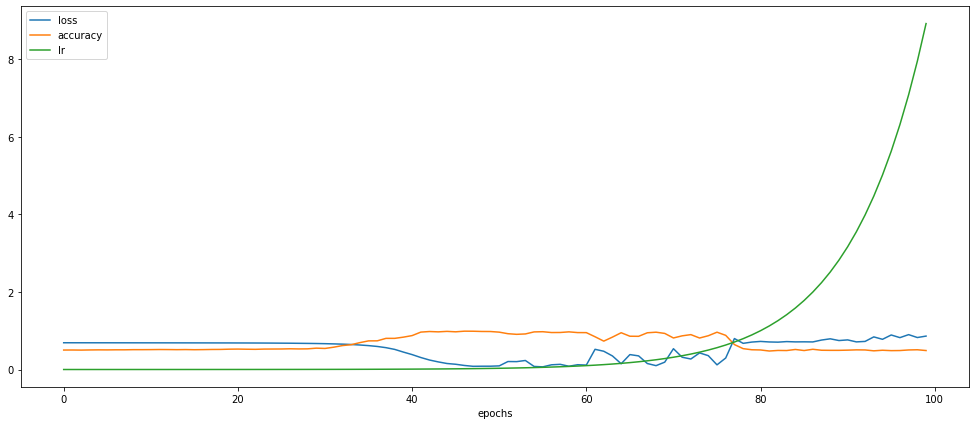

In [80]:
pd.DataFrame(history_8.history).plot(figsize=(17,7), xlabel="epochs");

As we can see that learning rate increases exponentially as the number of epochs increases.

And also we can see that model's accuracy goes up (and loss goes down) at a specific point when the learning rate slowly increases.

To figure out where this infliction point is, we can plot the loss versus the log-scale learning rate.

Text(0.5, 1.0, 'learning rate vs loss')

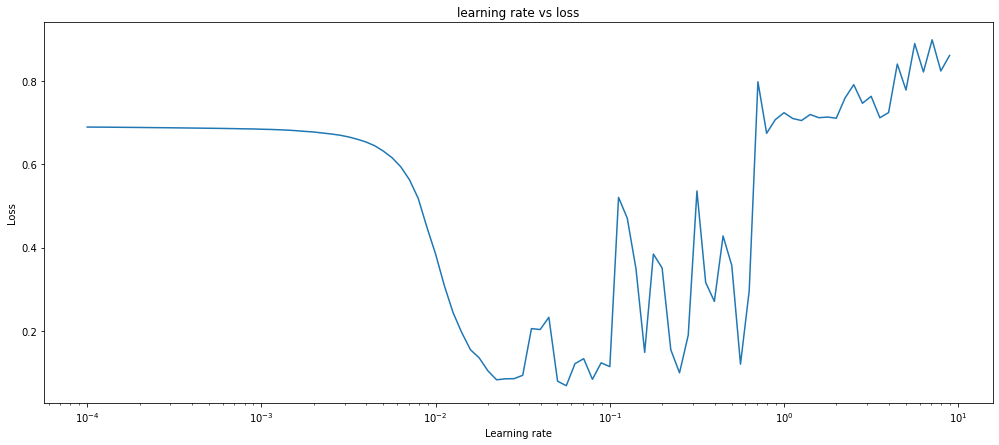

In [112]:
# Plot the learning rate versus loss

lrs = 1e-4 * (10**(tf.range(100)/20))
plt.figure(figsize=(17,7))
plt.semilogx(lrs, history_8.history['loss'])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("learning rate vs loss")


To figure out the ideal learning rate (at least the ideal value to begin with), the rule of thumb is to take the learning rate value where the loss is still decreasing but not quite flattened out (usually about 10x smaller than the bottom of the curve).

![Image](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-learning-rate-vs-loss.png)

In [120]:
# Example of other typical learning rate values
10**0, 10**-1, 10**-2, 10**-3, 10**-4

(1, 0.1, 0.01, 0.001, 0.0001)

Now we've estimated the ideal learning rate (we'll use between `0.01` - `0.001`), so let's choose `0.002` to build our model, and refit it

In [121]:
# random seed
tf.random.set_seed(17)

# Create the model
model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_9.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), # model_7 learning rate was 0.01 which has the highest accuracy of 99%
                metrics=['accuracy'])

# Fit the model
history_9 = model_9.fit(X_train, y_train, epochs=100)

Epoch 1/100
25/25 [==============================] - 1s 4ms/step - loss: 0.6892 - accuracy: 0.5013
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5138
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.5225
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 0.6847 - accuracy: 0.5213
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 0.6836 - accuracy: 0.5225
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5275
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6810 - accuracy: 0.5238
Epoch 8/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.5275
Epoch 9/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6768 - accuracy: 0.5288
Epoch 10/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6752 - accuracy: 0.5350
Epoch 11/

Awesome !

By adjusting the new learning rate `0.002`, we have better accuracy of 99.5% compared to learning rate of `0.01`

In [122]:
# Evaluate on test set
model_9.evaluate(X_test, y_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.1199 - accuracy: 0.9900


[0.11990191787481308, 0.9900000095367432]

313/313 [==============================] - 1s 2ms/step
doing binary classification...
313/313 [==============================] - 1s 4ms/step
doing binary classification...


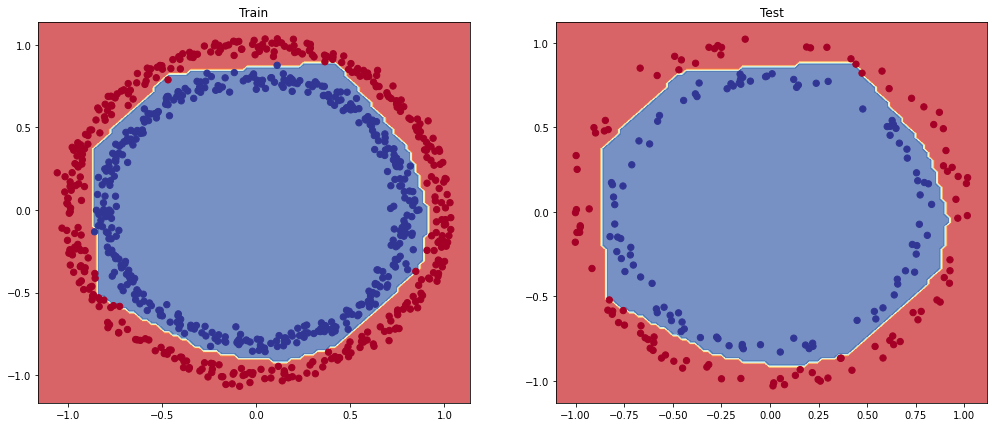

In [125]:
# Let's plot the predictions

plt.figure(figsize=(17,7))

# On training set
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_9, X_train, y_train)

# Test set
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_9, X_test, y_test)


plt.show();